In [1]:
import matplotlib.pyplot as plt

import openmc
from openmc.deplete import Results
from openmc.deplete.abc import _SECONDS_PER_MINUTE, _SECONDS_PER_HOUR, _SECONDS_PER_DAY
integrator_types = ('predictor', 'cecm')
time_types = [('minutes', _SECONDS_PER_MINUTE, 'minutes'), 
              ('hours', _SECONDS_PER_HOUR, 'hours'),
              ('days', _SECONDS_PER_DAY, 'days'),
              ('months', _SECONDS_PER_DAY, 'days')]
normalization_types = ('fission_q',)
depletion_types = [('simple', '../openmc/tests/chain_simple.xml'), ('full', 'chain_endbf71_pwr.xml')]


In [23]:
time_type = 0
integrator_type = 1
normalization_type = 1
depletion_type = 1

time_type, time_scale_factor, time_unit = time_types[time_type]
integrator_type = integrator_types[integrator_type]
normalization_type = normalization_types[normalization_type]
depletion_type, chain_file = depletion_types[depletion_type]

case1_results = Results(f'case1/{integrator_type}/{depletion_type}_depletion_results_{time_type}.h5')
case2_results = Results(f'case2/{integrator_type}/{depletion_type}_depletion_results_{time_type}.h5')

path = f'case3/{integrator_type}/{depletion_type}_depletion_results_{time_type}_'
case3_results = Results(path + '0.h5')
for i in range(1,10):
    case3_results.append(Results(path + f'{i}.h5')[1])

t = case1_results[0].time
for i, res in enumerate(case3_results):
    times = [0,0]
    times[0] = t[1] * i
    times[1] = t[1] * (i+1)
    res.time = times
        
time, _ = case1_results.get_atoms("1", "U235")
time /= time_scale_factor
chain = openmc.deplete.Chain.from_xml(chain_file)

atoms_dict = {}
rx_dict = {}
for nuc in chain.nuclides:
    nuc_name = nuc.name
    atoms = (case1_results.get_atoms("1", nuc_name)[1], 
             case2_results.get_atoms("1", nuc_name)[1],
             case3_results.get_atoms("1", nuc_name)[1])
    atoms_dict[nuc_name] = atoms
    rx_dict.update({nuc_name: {}})
    for rx in nuc.reactions:
        rx_name = rx.type
        reactions = (case1_results.get_reaction_rate('1', nuc_name, rx_name)[1],
                     case2_results.get_reaction_rate('1', nuc_name, rx_name)[1],
                     case3_results.get_reaction_rate('1', nuc_name, rx_name)[1])
        rx_dict[nuc_name].update({rx_name: reactions})

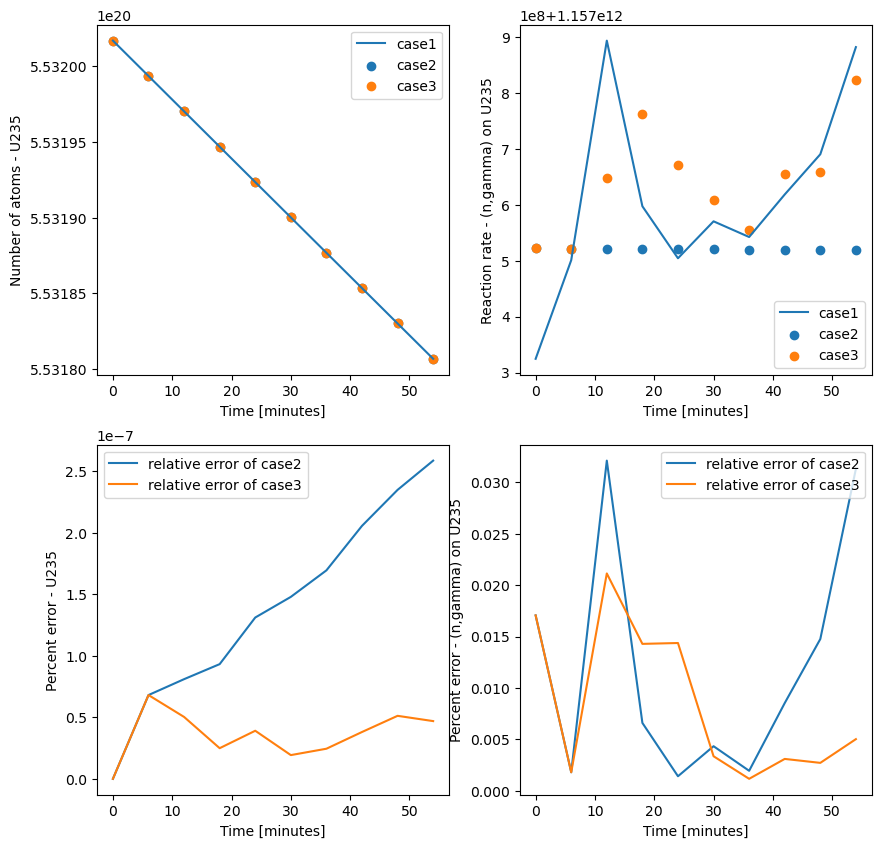

In [24]:
nuc = 'U235'
rx = '(n,gamma)'
i = -1
j = -1
c1_atoms, c2_atoms, c3_atoms = atoms_dict[nuc]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

ax1.plot(time[:i], c1_atoms[:i], label="case1")
ax1.scatter(time[:i], c2_atoms[:i], label="case2")
ax1.scatter(time[:i], c3_atoms[:i], label="case3")
ax1.set_xlabel(f"Time [{time_unit}]")
ax1.set_ylabel(f"Number of atoms - {nuc}");
ax1.legend()

at_error21 = 100 * abs((c2_atoms - c1_atoms) / c1_atoms)
at_error31 = 100 * abs((c3_atoms - c1_atoms) / c1_atoms)
at_error23 = 100 * abs((c2_atoms - c3_atoms) / c3_atoms)
ax3.plot(time[:j], at_error21[:j], label="relative error of case2")
ax3.plot(time[:j], at_error31[:j], label="relative error of case3")
ax3.set_xlabel(f"Time [{time_unit}]")
ax3.set_ylabel(f"Percent error - {nuc}")
ax3.legend()

if len(chain.nuclides[chain.nuclide_dict[nuc]].reactions) != 0:
    c1_nuc_rx, c2_nuc_rx, c3_nuc_rx = rx_dict[nuc][rx]
    ax2.plot(time[:i], c1_nuc_rx[:i], label="case1")
    ax2.scatter(time[:i], c2_nuc_rx[:i], label="case2")
    ax2.scatter(time[:i], c3_nuc_rx[:i], label="case3")
    ax2.set_xlabel(f"Time [{time_unit}]")
    ax2.set_ylabel(f"Reaction rate - {rx} on {nuc}");
    ax2.legend()

    rx_error21 = abs(100 * (c2_nuc_rx - c1_nuc_rx) / c1_nuc_rx)
    rx_error31 = abs(100 * (c3_nuc_rx - c1_nuc_rx) / c1_nuc_rx)
    rx_error23 = abs(100 * (c2_nuc_rx - c3_nuc_rx) / c3_nuc_rx)
    ax4.plot(time[:j], rx_error21[:j], label="relative error of case2")
    ax4.plot(time[:j], rx_error31[:j], label="relative error of case3")
    ax4.set_xlabel(f"Time [{time_unit}]")
    ax4.set_ylabel(f"Percent error - {rx} on {nuc}")
    ax4.legend()

## Figure Testing

In [5]:
time

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.])

In [30]:
from matplotlib import rcParams
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams['axes.axisbelow'] = True
rcParams['font.family'] = 'serif'
rcParams['pdf.use14corefonts'] = True
rcParams['savefig.bbox'] = 'tight'
rcParams['font.size'] = 12.0
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [49]:
actinides = [
    'U234', 'U235', 'U236', 'U238', 'U239', 'Np239',
    'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242',
    'Am241', 'Am242', 'Am242_m1', 'Am243', 'Am244',
    'Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246',
]

fission_products = [
    'Kr85', 'Sr90', 'Y90', 'Zr93', 'Mo95', 'Mo97', 'Tc99', 'Ru101', 'Ru106',
    'Rh103', 'Pd105', 'Pd107', 'Ag109', # 'Cd113_m1', 'Sn121_m1', 'Sn126',
    'Te132', 'I129', 'I131', 'Xe131', 'Xe135', 'Cs133', 'Cs134', 'Cs135', 'Cs137',
    'La139', 'Ce142', 'Nd143', 'Nd145', 'Pm147', 'Sm149', 'Sm151',
    # 'Eu155', 'Gd158',
]

#    time_type = 3
#    integrator_type = 0
#    normalization_type = 0
#    depletion_type = 1
integrator_types = ('predictor', 'cecm')
time_types = {'minutes': (_SECONDS_PER_MINUTE, 'minutes'), 
              'hours': (_SECONDS_PER_HOUR, 'hours'),
              'days': (_SECONDS_PER_DAY, 'days'),
              'months': (_SECONDS_PER_DAY, 'days')}
normalization_types = ('source_rate', 'fission_q')
depletion_types = {'simple': '../openmc/tests/chain_simple.xml', 'full': 'chain_endbf71_pwr.xml'}
#time_type = 'months'
#integrator_type = 'predictor'
#normalization_type = 'source_rate'
#depletion_type = 'full'

from openmc.data import ATOMIC_SYMBOL, zam
def sup_label(name):
    z, a, m = zam(name)
    meta = "\\text{m}" if m > 0 else ""
    sym = ATOMIC_SYMBOL[z]
    return f"$^{{{a}{meta}}}${sym}"

def load_results(time_type, integrator_type, normalization_type, depletion_type):
    time_scale_factor, time_unit = time_types[time_type]
    chain_file = depletion_types[depletion_type]

    case1_results = Results(f'case1/{integrator_type}/{depletion_type}_depletion_results_{time_type}.h5')
    case2_results = Results(f'case2/{integrator_type}/{depletion_type}_depletion_results_{time_type}.h5')

    path = f'case3/{integrator_type}/{depletion_type}_depletion_results_{time_type}_'
    case3_results = Results()
    for i in range(0,11):
        case3_results.append(Results(path + f'{i}.h5')[0])

    t = case1_results[0].time
    for i, res in enumerate(case3_results):
        times = [0,0]
        times[0] = t[1] * i
        times[1] = t[1] * (i+1)
        res.time = times

    time, _ = case1_results.get_atoms("1", "U235")
    time /= time_scale_factor
    chain = openmc.deplete.Chain.from_xml(chain_file)

    atoms_dict = {}
    rx_dict = {}
    nuclides = chain.nuclides
    for nuc in nuclides:
        nuc_name = nuc.name

        atoms = (case1_results.get_atoms("1", nuc_name)[1], 
                 case2_results.get_atoms("1", nuc_name)[1],
                 case3_results.get_atoms("1", nuc_name)[1])
        atoms_dict[nuc_name] = atoms
        rx_dict.update({nuc_name: {}})
        for rx in nuc.reactions:
            rx_name = rx.type
            reactions = (case1_results.get_reaction_rate('1', nuc_name, rx_name)[1],
                         case2_results.get_reaction_rate('1', nuc_name, rx_name)[1],
                         case3_results.get_reaction_rate('1', nuc_name, rx_name)[1])
            rx_dict[nuc_name].update({rx_name: reactions})
    return atoms_dict, rx_dict, time, time_unit


def isotope_bar_plot(atoms_dict, time, time_unit,
                     time_type, integrator_type, normalization_type, depletion_type,
                     nuclides, filename, decimals=2, **kwargs):

    print(f'{filename}...')

    #fig, (ax1, ax2) = plt.subplots(1, 2, **kwargs)
    for (case, case_name) in [(1, 'constant_xs'), (2, 'updating_xs')]:

        fig, ax = plt.subplots(**kwargs)
        burn_indices = (1, 4, 7, 10)
        burnup = time
        burnup_units = time_unit
        ind = np.arange(len(nuclides))
        height = 1/(len(burn_indices)+1)
        for i, index in enumerate(burn_indices):
            data_base = np.array([atoms_dict[nuc][0][index] for nuc in nuclides])
            data_case = np.array([atoms_dict[nuc][case][index] for nuc in nuclides])
            diff = np.zeros_like(data_case)
            nonzero = data_case > 0.0
            diff[nonzero] = (data_case[nonzero] - data_base[nonzero])/data_base[nonzero]
            ax.barh(ind + i*height, diff, height, label=f'{burnup[index]} {burnup_units}')

            #data_case1 = np.array([atoms_dict[nuc][0][index] for nuc in nuclides])
            #data_case2 = np.array([atoms_dict[nuc][1][index] for nuc in nuclides])
            #data_case3 = np.array([atoms_dict[nuc][2][index] for nuc in nuclides])
            #diff_case2 = np.zeros_like(data_case2)
            #diff_case3 = np.zeros_like(data_case3)
            #nonzero_case2 = data_case2 > 0.0
            #nonzero_case3 = data_case3 > 0.0
            #diff_case2[nonzero_case2] = (data_case2[nonzero_case2] - data_case1[nonzero_case2])/data_case1[nonzero_case2]
            #diff_case3[nonzero_case3] = (data_case3[nonzero_case3] - data_case1[nonzero_case3])/data_case1[nonzero_case3]

            #ax1.barh(ind + i*height, diff_case2, height, label=f'{burnup[index]} {burnup_units}')
            #ax2.barh(ind + i*height, diff_case3, height, label=f'{burnup[index]} {burnup_units}')


        locs = ind + height*(len(burn_indices)/2 - 0.5)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals))
        if decimals >= 3:
            ax.xaxis.set_tick_params(rotation=30)
        ax.set_xlabel('(Transport Independent - Transport Coupled)/Transport Coupled')
        ax.set_yticks(locs)
        ax.set_yticklabels([sup_label(x) for x in nuclides])
        ax.set_ylim(locs[0] - 0.5, locs[-1] + 0.5)
        ax.invert_yaxis()
        ax.legend()
        ax.grid()    
        fname = f'{filename}_{case_name}_{integrator_type}_{depletion_type}_{normalization_type}_{time_type}'
        plt.savefig(f'{fname}.pdf')

figs/actinides...
figs/fission_products...
figs/actinides...
figs/fission_products...
figs/actinides...
figs/fission_products...
figs/actinides...
figs/fission_products...


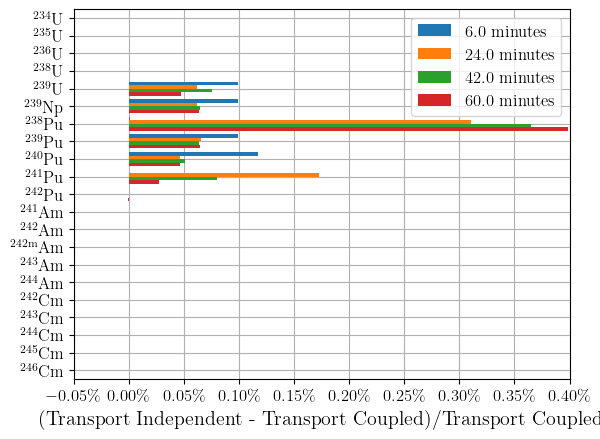

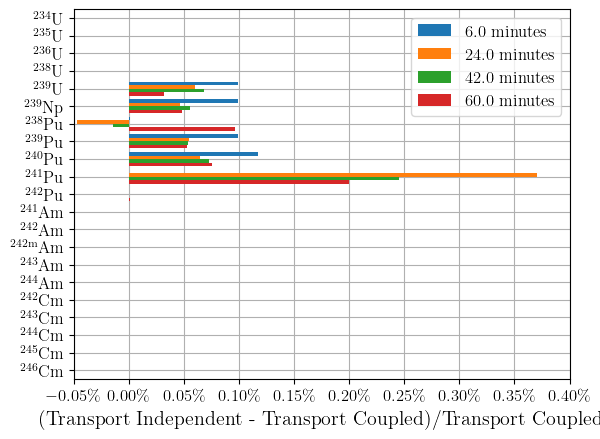

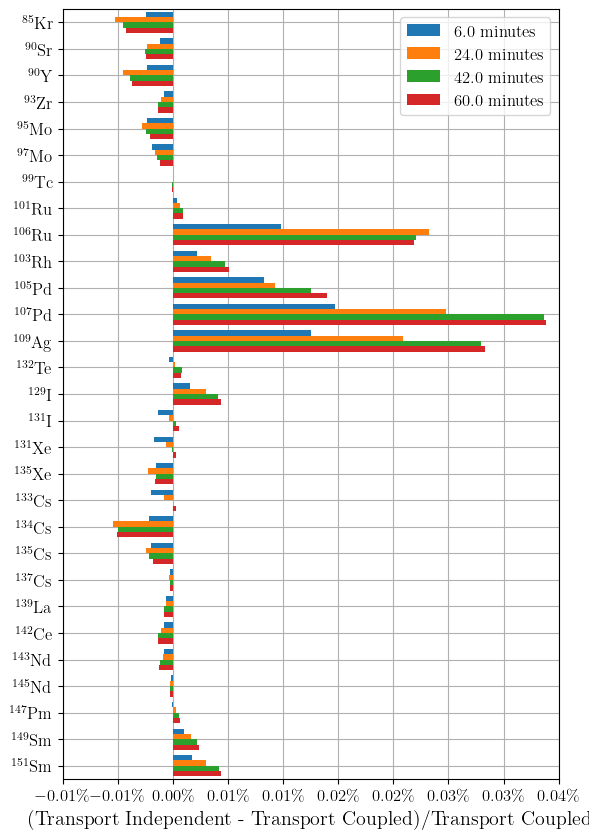

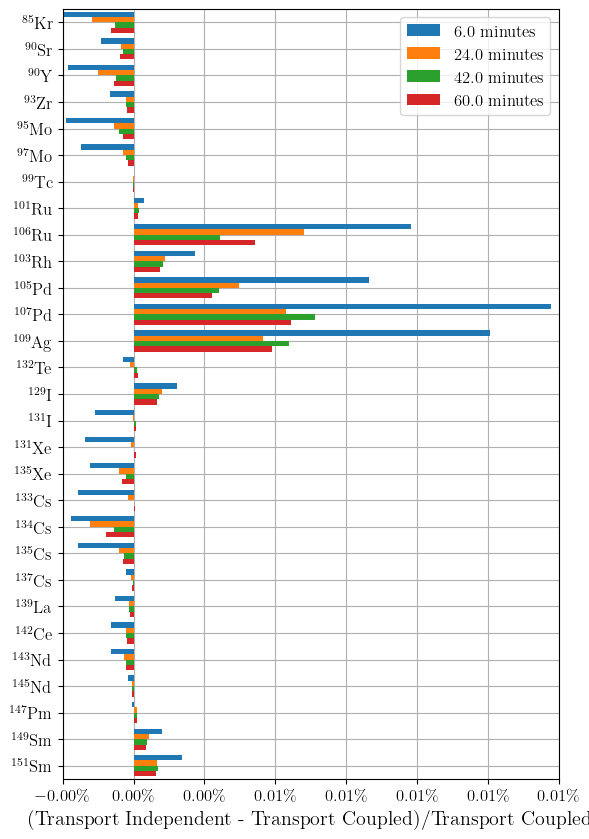

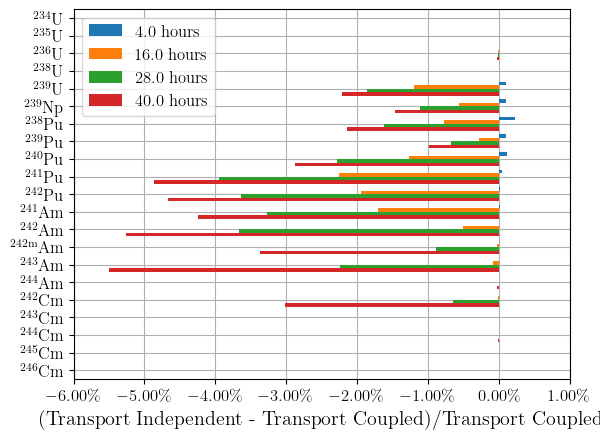

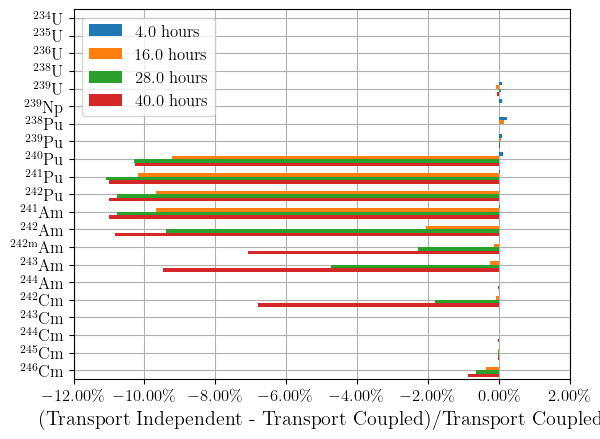

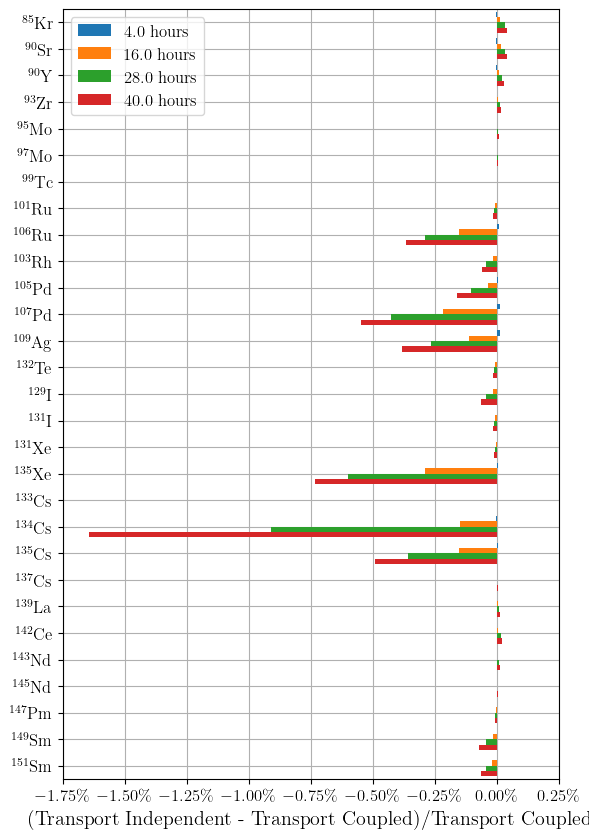

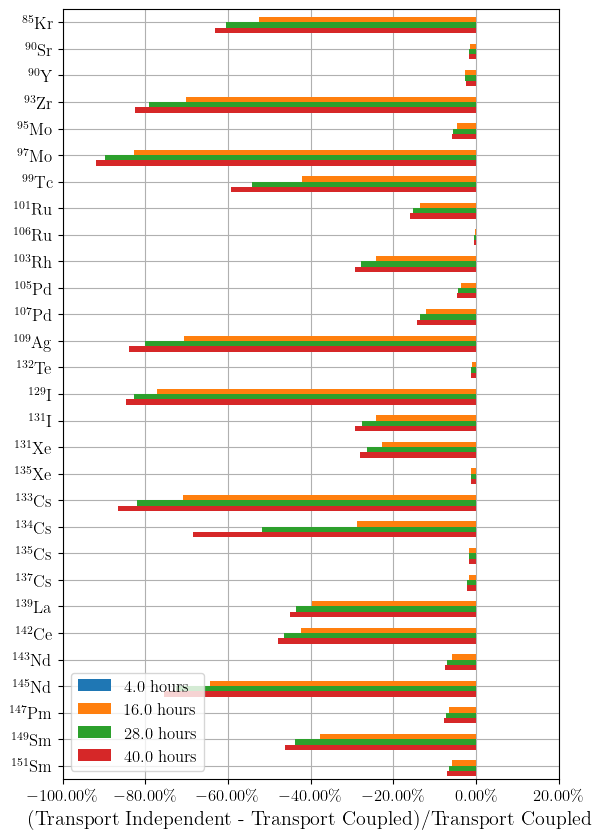

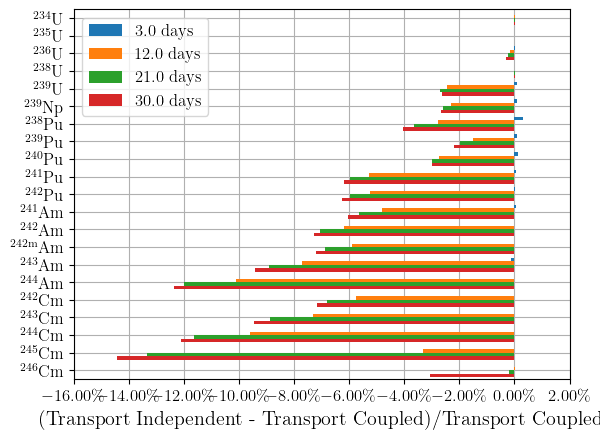

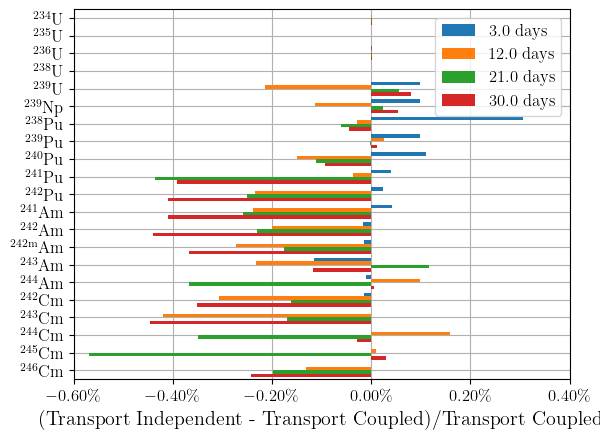

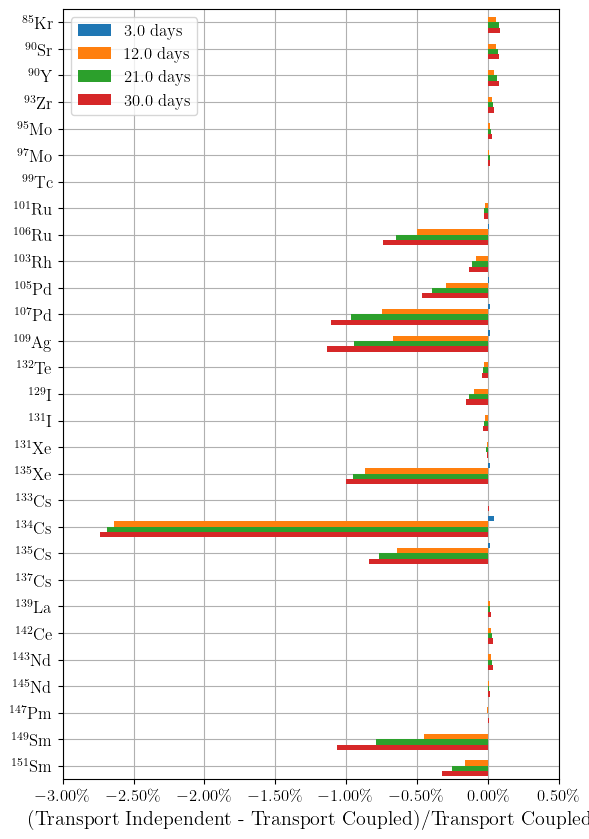

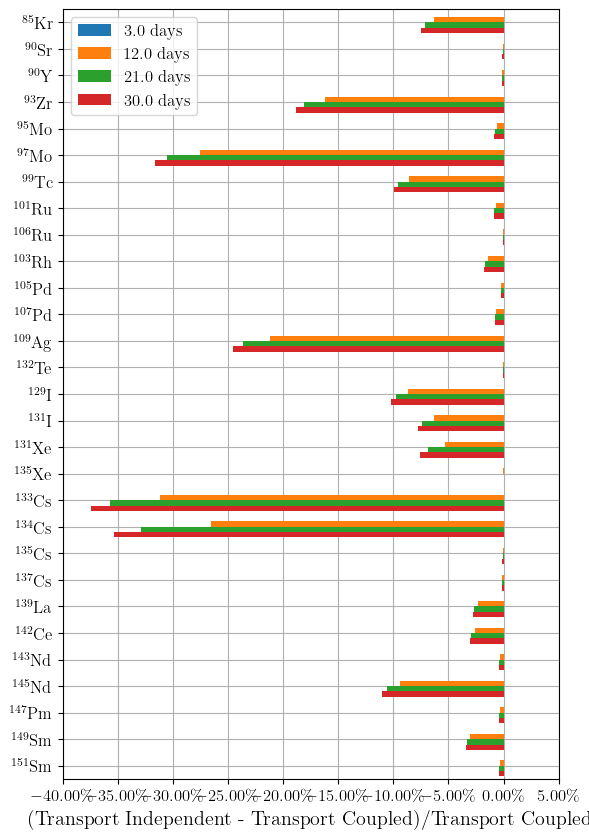

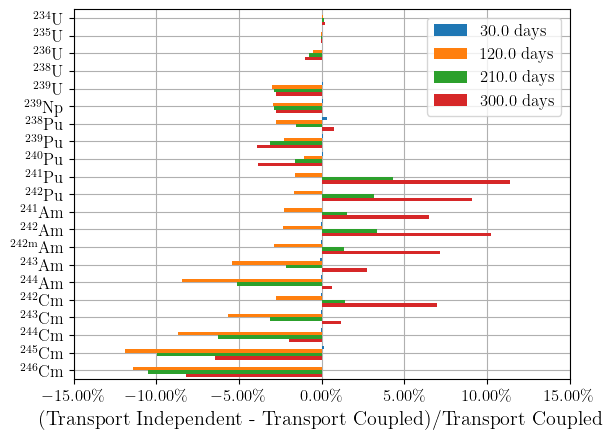

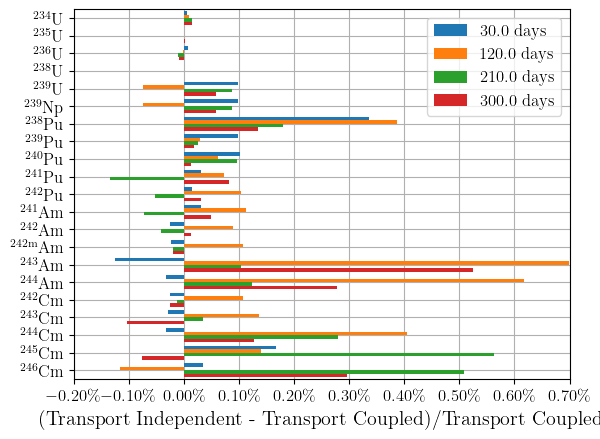

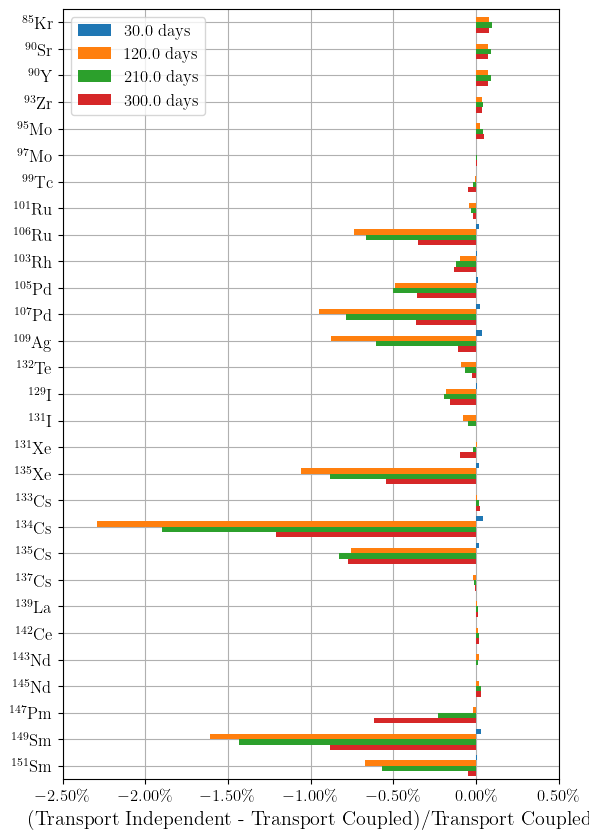

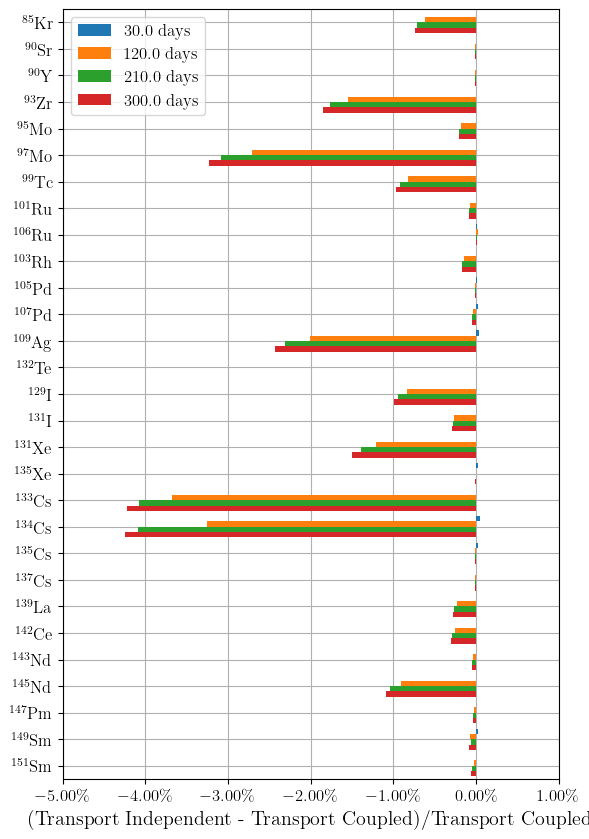

In [51]:
integrator_type = 'predictor'
normalization_type = 'fission_q'
depletion_type = 'full'
for time_type in time_types.keys():
    for integrator_type in integrator_types:
        
    atoms_dict, rx_dict, time, time_unit = load_results(time_type, integrator_type, normalization_type, depletion_type)
    isotope_bar_plot(atoms_dict, time, time_unit,
                     time_type, integrator_type, normalization_type, depletion_type,
                     actinides, 'figs/actinides')
    kwargs = {'figsize': (6.4, 10.0)}
    isotope_bar_plot(atoms_dict, time, time_unit,
                     time_type, integrator_type, normalization_type, depletion_type,
                     fission_products, 'figs/fission_products', **kwargs)

In [15]:
isinstance(nuc, str)

True

In [35]:
import numpy as np
import matplotlib.ticker as mtick